<p style ="text-align:center">
    <img src="http://epecora.com.br/DataFiles/BannerUFPR.png" width="700" alt="PPGOLD/PPGMNE Python:INTRO"  />
</p>

## Prof. Dr. Eduardo Pécora
## Prof. Dr. Cassius Scarpin

# **Simulação: Análise dos dados de entrada**

Neste notebook cobriremos os seguintes tópicos:

1. Análise de outliers
2. Análise de autocorrelação
3. Teste de hipóteses


## Importar as bibliotecas necessárias

In [39]:
import numpy as np
import pandas as pd
import math

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from scipy import stats

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

np.set_printoptions(legacy='1.25')

## Ler os dados

In [40]:
data_df = pd.read_csv("/content/Dist03.csv")
data = data_df[data_df.columns[0]].to_numpy()

## Analise descritiva

In [41]:
data_df.describe()

,normal
count,1000.000000
mean,0.023155
std,0.986490
min,-3.178055
25%,-0.690618
50%,0.031530
75%,0.733336
max,3.322772


## Algoritmos de detecção de outliers

In [42]:
def detect_outliers_iqr(data):
  Q1 = np.percentile(data, 25)
  Q3 = np.percentile(data, 75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = [x for x in data if x < lower_bound or x > upper_bound]
  return outliers

def detect_outliers_isolation_forest(data):
  model = IsolationForest(contamination='auto', random_state=42)  # Adjust contamination as needed
  model.fit(data.reshape(-1, 1))
  outlier_scores = model.decision_function(data.reshape(-1, 1))
  outliers = data[outlier_scores < 0]
  return outliers

def detect_outliers_local_outlier_factor(data):
  model = LocalOutlierFactor(n_neighbors=20, contamination='auto') # Adjust n_neighbors and contamination as needed
  outlier_scores = model.fit_predict(data.reshape(-1, 1))
  outliers = data[outlier_scores == -1]
  return outliers

# Outlier detection using IQR
iqr_outliers = detect_outliers_iqr(data)

# Outlier detection using Isolation Forest
isolation_forest_outliers = detect_outliers_isolation_forest(data)

# Outlier detection using Local Outlier Factor
lof_outliers = detect_outliers_local_outlier_factor(data)

# Assuming you have the outlier lists from the previous code
iqr_outliers = detect_outliers_iqr(data)
isolation_forest_outliers = detect_outliers_isolation_forest(data)
lof_outliers = detect_outliers_local_outlier_factor(data)

# Convert to sets for easy intersection
iqr_outliers_set = set(iqr_outliers)
isolation_forest_outliers_set = set(isolation_forest_outliers)
lof_outliers_set = set(lof_outliers)

# Find the intersection of all outlier sets
common_outliers = iqr_outliers_set.intersection(isolation_forest_outliers_set, lof_outliers_set)

print("Outliers identified by all methods:", list(common_outliers))

Outliers identified by all methods: [3.316189666828753, 3.322772392593383, -3.1780549012125188]


## Análise de auto-correlação

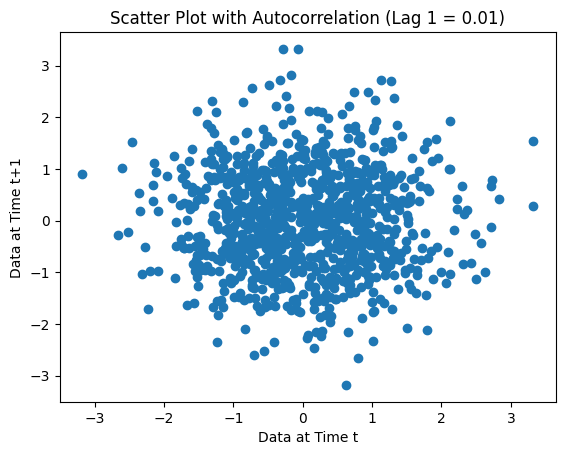

In [43]:
# Calculate autocorrelation with lag 1
autocorrelation_lag1 = pd.Series(data).autocorr(lag=1)

# Create a scatter plot of the data against the lagged data
plt.scatter(data[:-1], data[1:])
plt.xlabel("Data at Time t")
plt.ylabel("Data at Time t+1")
plt.title("Scatter Plot with Autocorrelation (Lag 1 = " + str(round(autocorrelation_lag1, 2)) + ")")
plt.show()


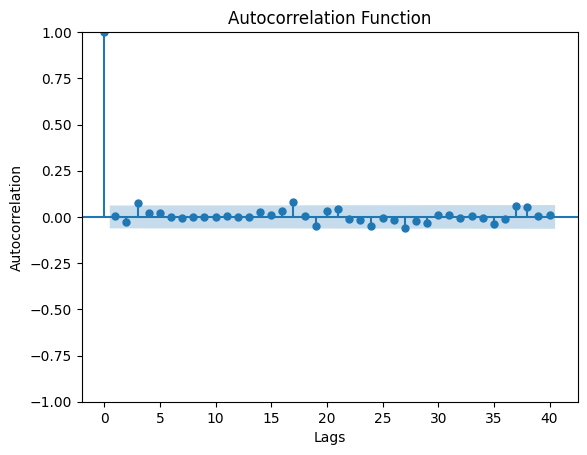

In [44]:
# Calculate autocorrelation function
# You can specify the number of lags to consider with the 'lags' parameter
acf_values = plot_acf(data, lags=40)

# Plot the autocorrelation function
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function")
plt.show()


## Testes de hipóteses

/usr/local/lib/python3.12/dist-packages/scipy/stats/_continuous_distns.py:6921: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


Results of Distribution Fit Tests:
- Normal:
  p-value: 0.4594
  Fits distribution: True
  Parameters: (0.023155397487630066, 0.9859968884102918)

- Uniform:
  p-value: 0.0000
  Fits distribution: False
  Parameters: (-3.1780549012125188, 6.5008272938059015)

- Exponential:
  p-value: 0.0000
  Fits distribution: False
  Parameters: (-3.1780549012125188, 3.2012102987001487)

- Gamma:
  p-value: 0.4754
  Fits distribution: True
  Parameters: (422.3501873843964, -20.241427852643213, 0.047980524415384765)

- Weibull:
  p-value: 0.6996
  Fits distribution: True
  Parameters: (3.332902729705271, -2.9605366001066313, 3.326020133393065)

- Beta:
  p-value: 0.5793
  Fits distribution: True
  Parameters: (26.813731041459576, 39.198206378625606, -6.652536897332968, 16.434681662103223)

- Lognormal:
  p-value: 0.4751
  Fits distribution: True
  Parameters: (0.03196005375241377, -30.821293529410987, 30.828704257674133)



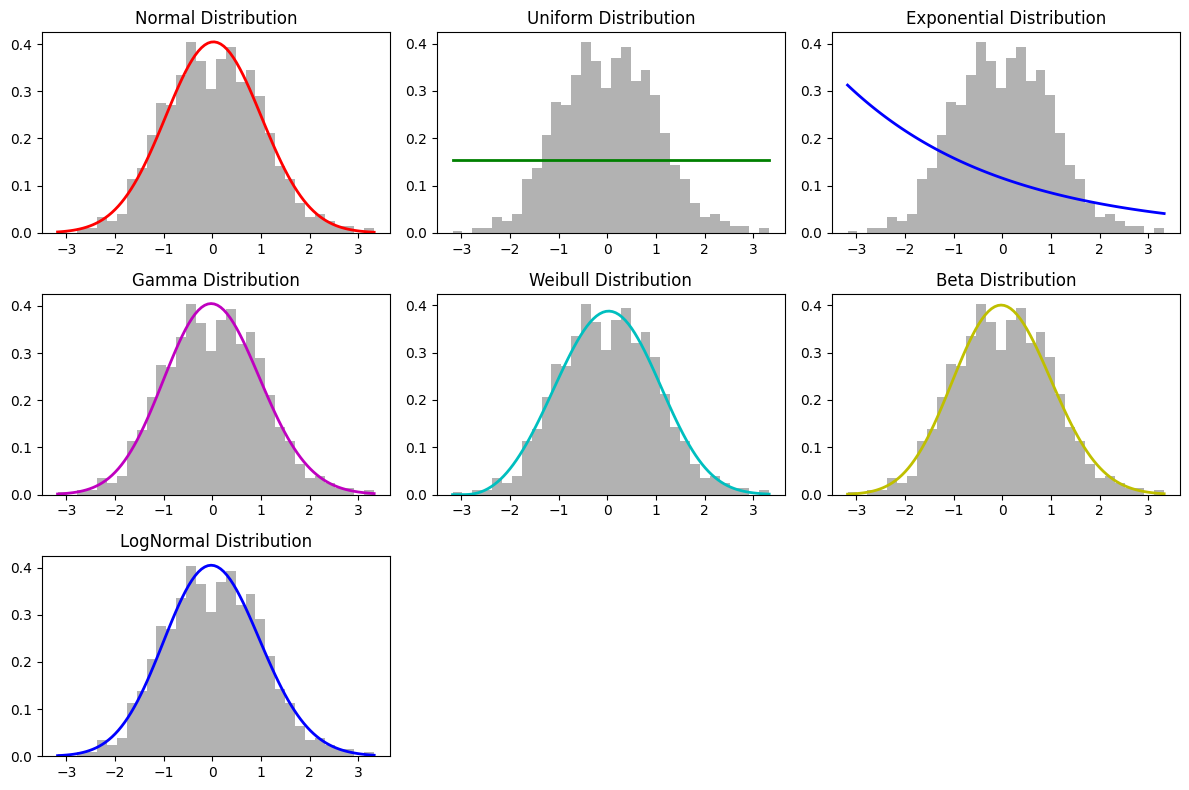

In [45]:
def test_distribution_fit(data):

  results = {}

  # Test for normality
  normal_params = stats.norm.fit(data)
  _, p_normal = stats.normaltest(data)
  results['normal'] = {'p-value': p_normal, 'fits': p_normal > 0.05, 'parameters': normal_params}

  # Test for uniformity
  uniform_params = stats.uniform.fit(data)
  _, p_uniform = stats.kstest(data, 'uniform', args=(np.min(data), np.max(data)))
  results['uniform'] = {'p-value': p_uniform, 'fits': p_uniform > 0.05, 'parameters': uniform_params}

  # Test for exponentiality
  exponential_params = stats.expon.fit(data)
  _, p_exponential = stats.kstest(data, 'expon')
  results['exponential'] = {'p-value': p_exponential, 'fits': p_exponential > 0.05, 'parameters': exponential_params}

  # Test for Gamma distribution
  gamma_params = stats.gamma.fit(data)
  _, p_gamma = stats.kstest(data, 'gamma', args=gamma_params)
  results['gamma'] = {'p-value': p_gamma, 'fits': p_gamma > 0.05, 'parameters': gamma_params}

  # Test for Weibull distribution
  weibull_params = stats.weibull_min.fit(data)
  _, p_weibull = stats.kstest(data, 'weibull_min', args=weibull_params)
  results['weibull'] = {'p-value': p_weibull, 'fits': p_weibull > 0.05, 'parameters': weibull_params}

  # Test for Beta distribution
  beta_params = stats.beta.fit(data)
  _, p_beta = stats.kstest(data, 'beta', args=beta_params)
  results['beta'] = {'p-value': p_beta, 'fits': p_beta > 0.05, 'parameters': beta_params}

  # Test for lognormal distribution
  logn_params = stats.lognorm.fit(data)  # Returns shape, loc, scale
  _, p_logn = stats.kstest(data, 'lognorm', args=logn_params)
  results['lognormal'] = {'p-value': p_logn, 'fits': p_logn > 0.05, 'parameters': logn_params}

  return results


results = test_distribution_fit(data)

print("Results of Distribution Fit Tests:")
for distribution, result in results.items():
  print(f"- {distribution.capitalize()}:")
  print(f"  p-value: {result['p-value']:.4f}")
  print(f"  Fits distribution: {result['fits']}")
  if 'parameters' in result:
    print(f"  Parameters: {result['parameters']}\n")


# Plot histograms and distribution lines for different distributions
plt.figure(figsize=(12, 8))

# Plot the distributions (you can adjust which ones to plot based on the results)

bins = math.ceil(math.sqrt(data.shape[0]))

plt.subplot(3, 3, 1)
plt.hist(data, bins=bins, density=True, alpha=0.6, color='gray')
x = np.linspace(np.min(data), np.max(data), 100)
y = stats.norm.pdf(x, np.mean(data), np.std(data))
plt.plot(x, y, 'r-', lw=2)
plt.title("Normal Distribution")

plt.subplot(3, 3, 2)
plt.hist(data, bins=bins, density=True, alpha=0.6, color='gray')
x = np.linspace(np.min(data), np.max(data), 100)
y = stats.uniform.pdf(x, loc=np.min(data), scale=np.max(data) - np.min(data))
plt.plot(x, y, 'g-', lw=2)
plt.title("Uniform Distribution")

plt.subplot(3, 3, 3)
plt.hist(data, bins=bins, density=True, alpha=0.6, color='gray')
x = np.linspace(np.min(data), np.max(data), 100)
y = stats.expon.pdf(x, loc=np.min(data), scale=stats.expon.fit(data)[1])
plt.plot(x, y, 'b-', lw=2)
plt.title("Exponential Distribution")

plt.subplot(3, 3, 4)
plt.hist(data, bins=bins, density=True, alpha=0.6, color='gray')
x = np.linspace(np.min(data), np.max(data), 100)
y = stats.gamma.pdf(x, *stats.gamma.fit(data))
plt.plot(x, y, 'm-', lw=2)
plt.title("Gamma Distribution")

plt.subplot(3, 3, 5)
plt.hist(data, bins=bins, density=True, alpha=0.6, color='gray')
x = np.linspace(np.min(data), np.max(data), 100)
y = stats.weibull_min.pdf(x, *stats.weibull_min.fit(data))
plt.plot(x, y, 'c-', lw=2)
plt.title("Weibull Distribution")

plt.subplot(3, 3, 6)
plt.hist(data, bins=bins, density=True, alpha=0.6, color='gray')
x = np.linspace(np.min(data), np.max(data), 100)
y = stats.beta.pdf(x, *stats.beta.fit(data))
plt.plot(x, y, 'y-', lw=2)
plt.title("Beta Distribution")

plt.subplot(3, 3, 7)
plt.hist(data, bins=bins, density=True, alpha=0.6, color='gray')
x = np.linspace(np.min(data), np.max(data), 100)
y = stats.lognorm.pdf(x, *stats.lognorm.fit(data))
plt.plot(x, y, 'b-', lw=2)
plt.title("LogNormal Distribution")

plt.tight_layout()
plt.show()

## Fique Conectado

- [![YouTube](https://img.icons8.com/?size=40&id=19318&format=png&color=000000)](https://www.youtube.com/@LigaDataScience/videos)  
  Explore nossos vídeos educacionais e webinars sobre ciência de dados, machine learning e inteligência artificial. Inscreva-se para não perder nenhuma atualização!

- [![LinkedIn](https://img.icons8.com/?size=40&id=13930&format=png&color=000000)](https://www.linkedin.com/company/liga-data-science-ufpr/)  
  Siga-nos no LinkedIn para as últimas novidades, oportunidades de carreira e networking profissional no campo da ciência de dados.

- [![Instagram](https://img.icons8.com/?size=40&id=32323&format=png&color=000000)](https://www.instagram.com/ligadatascience/)  
  Confira nosso Instagram para conteúdos dos bastidores, destaques de eventos e o dia a dia da Liga Data Science. Faça parte da nossa jornada!
  
  ## Autores

<a href="https://www.linkedin.com/in/eduardopecora/" target="_blank">Eduardo Pecora</a>

<a href="https://www.linkedin.com/in/cassius-scarpin-03062324/" target="_blank">Cassius Scarpin</a>

## Log de modificações

| Data | Versão | Modificado por | Descrição |
| ----------------- | ------- | ---------- | ---------------------------------- |
| 20-03-2025       | 1.0     | Eduardo Pecora & Cassius Scarpin| Inicial               |

<hr>

## <h3 align="center"> (c) Liga Data Science/ UFPR 2024. All rights reserved. <h3/>